In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys
print(sys.version)
%matplotlib inline

3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]


In [2]:
train_image_folder = "../VOCdevkit/VOC2012/JPEGImages/"
train_annot_folder = "../VOCdevkit/VOC2012/Annotations/"

LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

ANCHORS = np.array([1.07709888,  1.78171903,  # anchor box 1, width , height
                    2.71054693,  5.12469308,  # anchor box 2, width,  height
                   10.47181473, 10.09646365,  # anchor box 3, width,  height
                    5.48531347,  8.11011331]) # anchor box 4, width,  height


BOX               = int(len(ANCHORS)/2)
TRUE_BOX_BUFFER   = 50
IMAGE_H, IMAGE_W  = 416, 416
GRID_H,  GRID_W   = 13 , 13

In [3]:
from backend import define_YOLOv2
from backend import PreTrainedYOLODetector
CLASS             = len(LABELS)
model, _          = define_YOLOv2(IMAGE_H,IMAGE_W,GRID_H,GRID_W,TRUE_BOX_BUFFER,BOX,CLASS, 
                                  trainable=False)
model.load_weights("weights_yolo_on_voc2012.h5")

Using TensorFlow backend.


In [4]:
## input encoding
from backend import ImageReader
imageReader = ImageReader(IMAGE_H,IMAGE_W=IMAGE_W, norm=lambda image : image / 255.)
out = imageReader.fit(train_image_folder + "/2007_005430.jpg")

In [5]:
print(out.shape)
X_test = np.expand_dims(out,0)
print(X_test.shape)
# handle the hack input
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))
y_pred = model.predict([X_test,dummy_array])
print(y_pred.shape)

(416, 416, 3)
(1, 416, 416, 3)
(1, 13, 13, 4, 25)


In [11]:
from backend import OutputRescaler
netout         = y_pred[0]
outputRescaler = OutputRescaler(ANCHORS=ANCHORS)
netout_scale   = outputRescaler.fit(netout)

In [8]:
from backend import BoundBox

    
def find_high_class_probability_bbox(netout_scale, obj_threshold):
    '''
    == Input == 
    netout : y_pred[i] np.array of shape (GRID_H, GRID_W, BOX, 4 + 1 + N class)
    
             x, w must be a unit of image width
             y, h must be a unit of image height
             c must be in between 0 and 1
             p^c must be in between 0 and 1
    == Output ==
    
    boxes  : list containing bounding box with Pr(object is in class C) > 0 for at least in one class C 
    
             
    '''
    GRID_H, GRID_W, BOX = netout_scale.shape[:3]
    
    boxes = []
    for row in range(GRID_H):
        for col in range(GRID_W):
            for b in range(BOX):
                # from 4th element onwards are confidence and class classes
                classes = netout_scale[row,col,b,5:]
                
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout_scale[row,col,b,:4]
                    confidence = netout_scale[row,col,b,4]
                    box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    if box.get_score() > obj_threshold:
                        boxes.append(box)
    return(boxes)

In [9]:
obj_threshold = 0.015
boxes_tiny_threshold = find_high_class_probability_bbox(netout_scale,obj_threshold)
print("obj_threshold={}".format(obj_threshold))
print("In total, YOLO can produce GRID_H * GRID_W * BOX = {} bounding boxes ".format( GRID_H * GRID_W * BOX))
print("I found {} bounding boxes with top class probability > {}".format(len(boxes_tiny_threshold),obj_threshold))

obj_threshold = 0.03
boxes = find_high_class_probability_bbox(netout_scale,obj_threshold)
print("\nobj_threshold={}".format(obj_threshold))
print("In total, YOLO can produce GRID_H * GRID_W * BOX = {} bounding boxes ".format( GRID_H * GRID_W * BOX))
print("I found {} bounding boxes with top class probability > {}".format(len(boxes),obj_threshold))

obj_threshold=0.015
In total, YOLO can produce GRID_H * GRID_W * BOX = 676 bounding boxes 
I found 496 bounding boxes with top class probability > 0.015

obj_threshold=0.03
In total, YOLO can produce GRID_H * GRID_W * BOX = 676 bounding boxes 
I found 112 bounding boxes with top class probability > 0.03


Plot with low object threshold
person     0.017 xmin=   0,ymin=   0,xmax= 104,ymax= 116
person     0.016 xmin=  27,ymin=   0,xmax=  67,ymax=  42
person     0.018 xmin=   0,ymin=   0,xmax=  98,ymax=  81
person     0.025 xmin=   0,ymin=   0,xmax= 128,ymax= 125
person     0.022 xmin=   0,ymin=   0,xmax= 160,ymax= 121
person     0.022 xmin=  24,ymin=   0,xmax= 194,ymax= 128
person     0.021 xmin=  53,ymin=   0,xmax= 229,ymax= 126
person     0.021 xmin=  85,ymin=   0,xmax= 261,ymax= 125


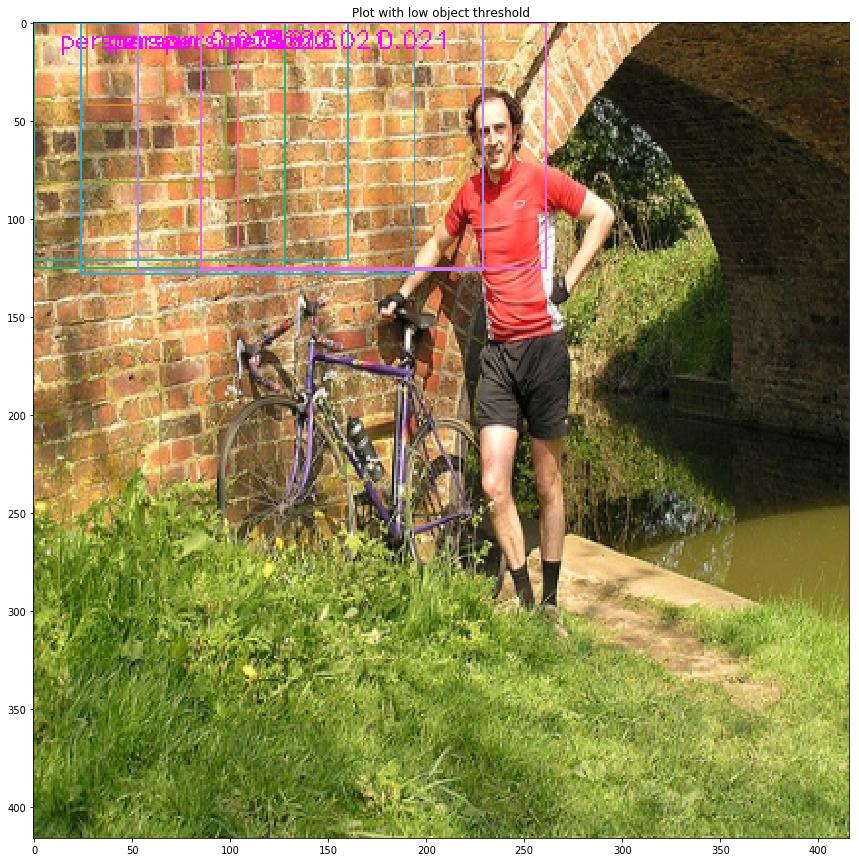

Plot with high object threshold
person     0.030 xmin=   0,ymin=   0,xmax= 170,ymax= 178
person     0.034 xmin=   0,ymin=   0,xmax= 131,ymax= 226
person     0.033 xmin=   0,ymin=   0,xmax= 166,ymax= 220
person     0.034 xmin=  20,ymin=   0,xmax= 200,ymax= 219
person     0.030 xmin=  48,ymin=   0,xmax= 237,ymax= 208
person     0.034 xmin= 125,ymin=   0,xmax= 288,ymax= 210
person     0.030 xmin= 194,ymin=  12,xmax= 285,ymax= 150
person     0.038 xmin=   0,ymin=   0,xmax= 128,ymax= 261


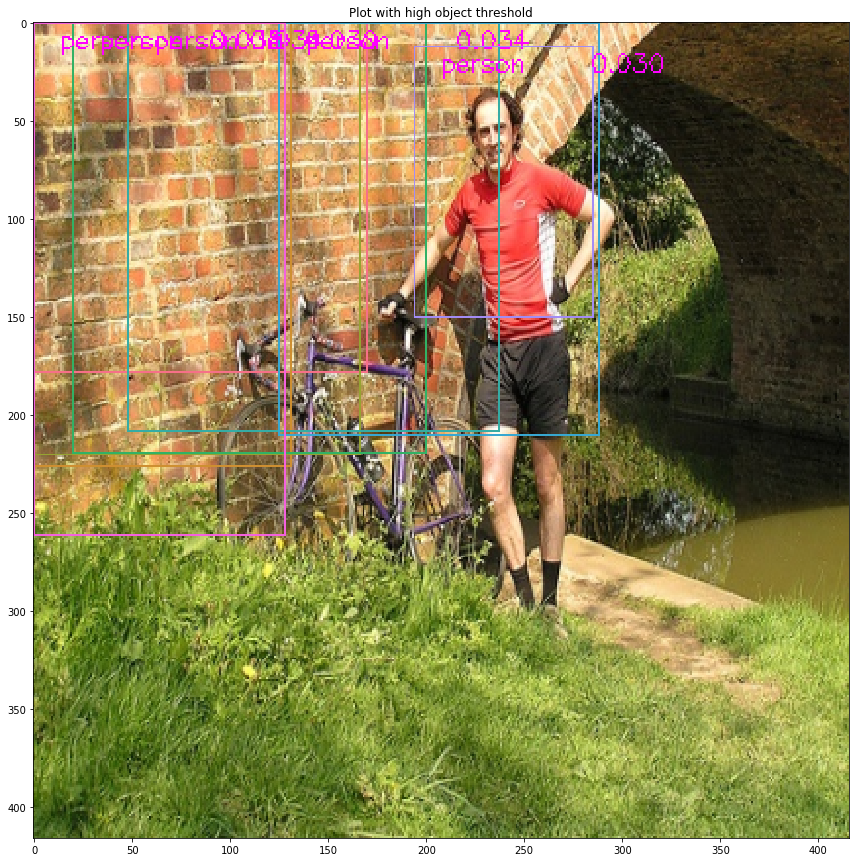

In [10]:
import cv2, copy
import seaborn as sns
def draw_boxes(image, boxes, labels, obj_baseline=0.05,verbose=False):
    '''
    image : np.array of shape (N height, N width, 3)
    '''
    def adjust_minmax(c,_max):
        if c < 0:
            c = 0   
        if c > _max:
            c = _max
        return c
    
    image = copy.deepcopy(image)
    image_h, image_w, _ = image.shape
    score_rescaled  = np.array([box.get_score() for box in boxes])
    score_rescaled /= obj_baseline
    
    colors = sns.color_palette("husl", 8)
    for sr, box,color in zip(score_rescaled,boxes, colors):
        xmin = adjust_minmax(int(box.xmin*image_w),image_w)
        ymin = adjust_minmax(int(box.ymin*image_h),image_h)
        xmax = adjust_minmax(int(box.xmax*image_w),image_w)
        ymax = adjust_minmax(int(box.ymax*image_h),image_h)
 
        
        text = "{:10} {:4.3f}".format(labels[box.label], box.get_score())
        if verbose:
            print("{} xmin={:4.0f},ymin={:4.0f},xmax={:4.0f},ymax={:4.0f}".format(text,xmin,ymin,xmax,ymax,text))
        cv2.rectangle(image, 
                      pt1=(xmin,ymin), 
                      pt2=(xmax,ymax), 
                      color=color, 
                      thickness=sr)
        cv2.putText(img       = image, 
                    text      = text, 
                    org       = (xmin+ 13, ymin + 13),
                    fontFace  = cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale = 1e-3 * image_h,
                    color     = (1, 0, 1),
                    thickness = 1)
        
    return image


print("Plot with low object threshold")
ima = draw_boxes(X_test[0],boxes_tiny_threshold,LABELS,verbose=True)
figsize = (15,15)
plt.figure(figsize=figsize)
plt.imshow(ima); 
plt.title("Plot with low object threshold")
plt.show()

print("Plot with high object threshold")
ima = draw_boxes(X_test[0],boxes,LABELS,verbose=True)
figsize = (15,15)
plt.figure(figsize=figsize)
plt.imshow(ima); 
plt.title("Plot with high object threshold")
plt.show()